
=== Running test config: Req20_Veh4_Reg0.1 ===
Map saved to routes_Req20_Veh4_Reg0.1_20250321_101145.html

=== Running test config: Req30_Veh6_Reg0.2 ===
Map saved to routes_Req30_Veh6_Reg0.2_20250321_101215.html

=== Running test config: Req10_Veh2_Reg0.05 ===
Map saved to routes_Req10_Veh2_Reg0.05_20250321_101245.html

--- Raw Results (All Configurations) ---
               Config  NumRequests  NumVehicles  RegionSize  distance_miles  \
0   Req20_Veh4_Reg0.1           20            4        0.10          78.791   
1   Req30_Veh6_Reg0.2           30            6        0.20         181.215   
2  Req10_Veh2_Reg0.05           10            2        0.05          32.061   

   sim_time_min  
0       157.582  
1       362.430  
2        64.122  


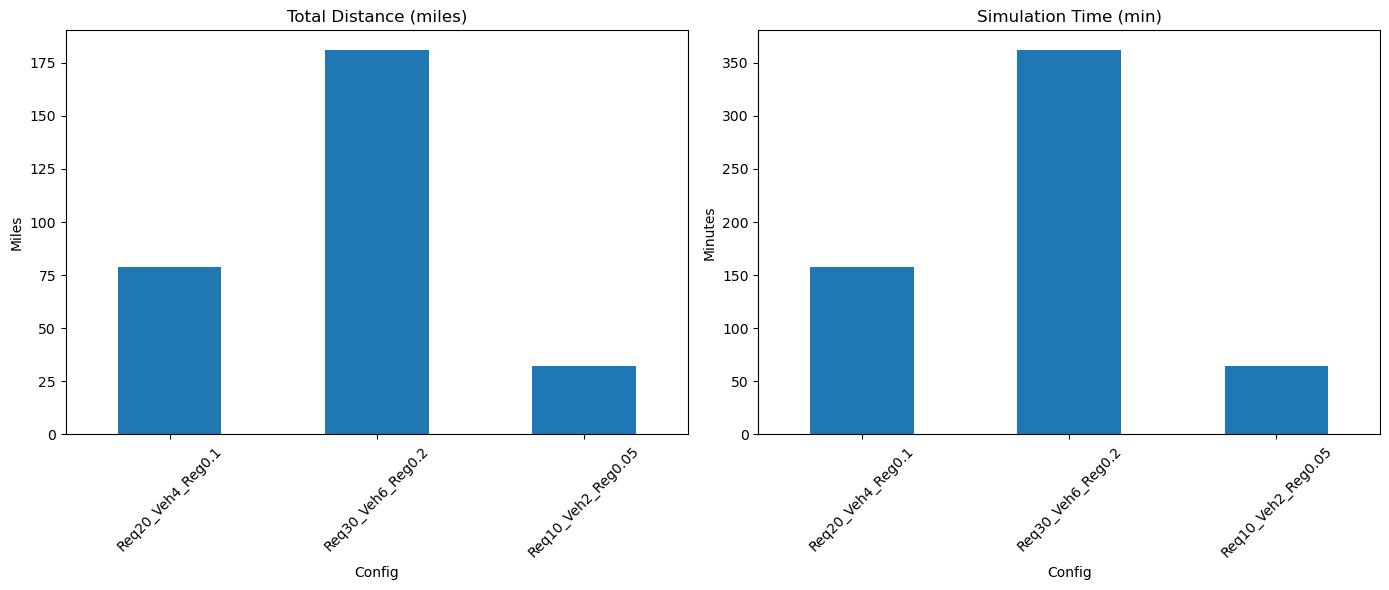

Basic grouped bar chart saved to grouped_comparison.png
Results page saved to results.html


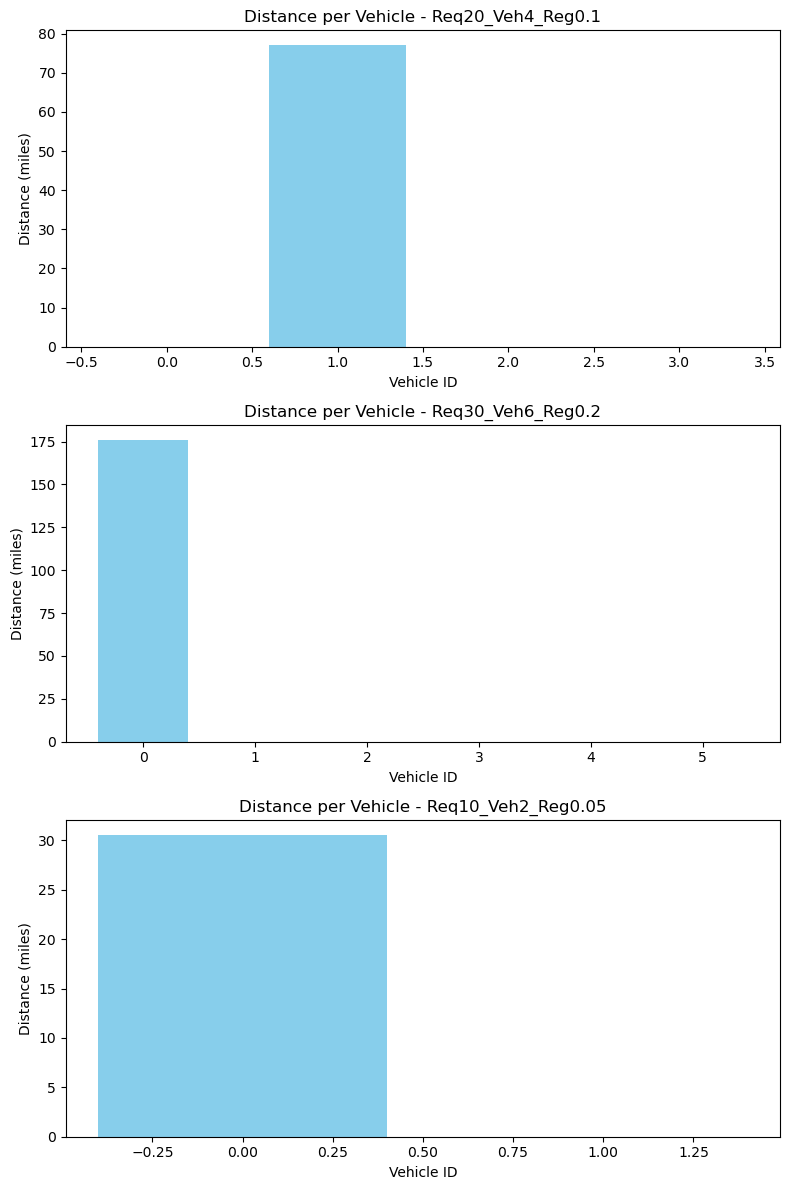

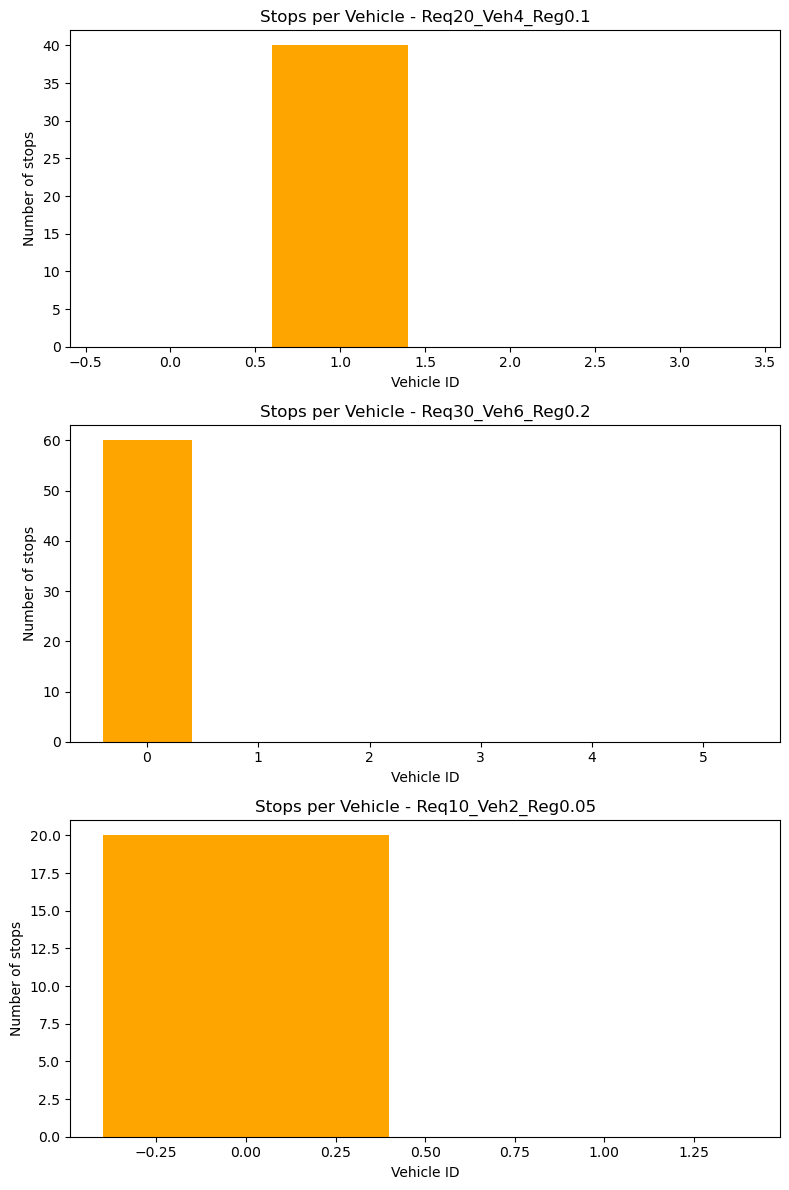

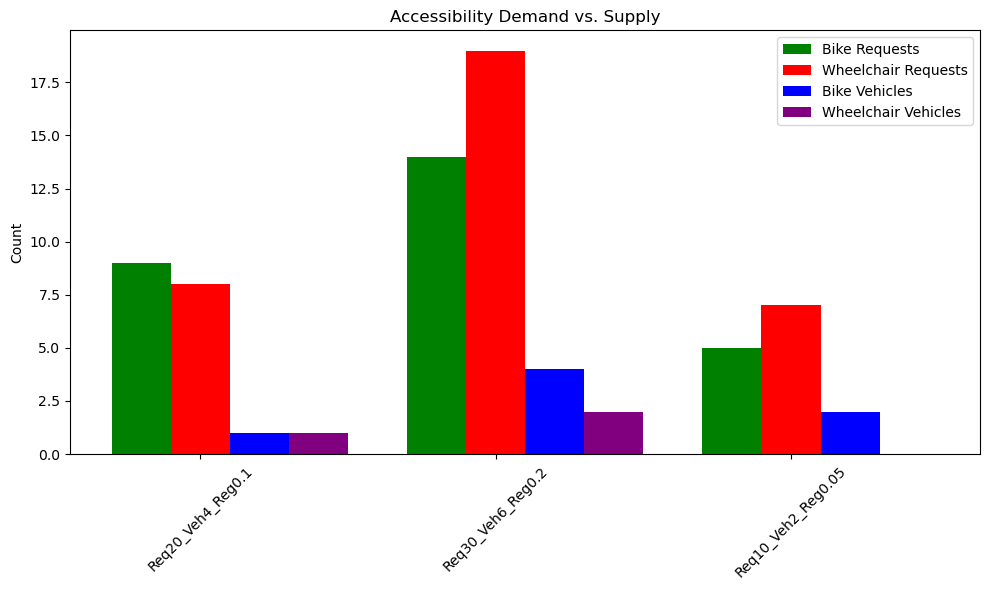

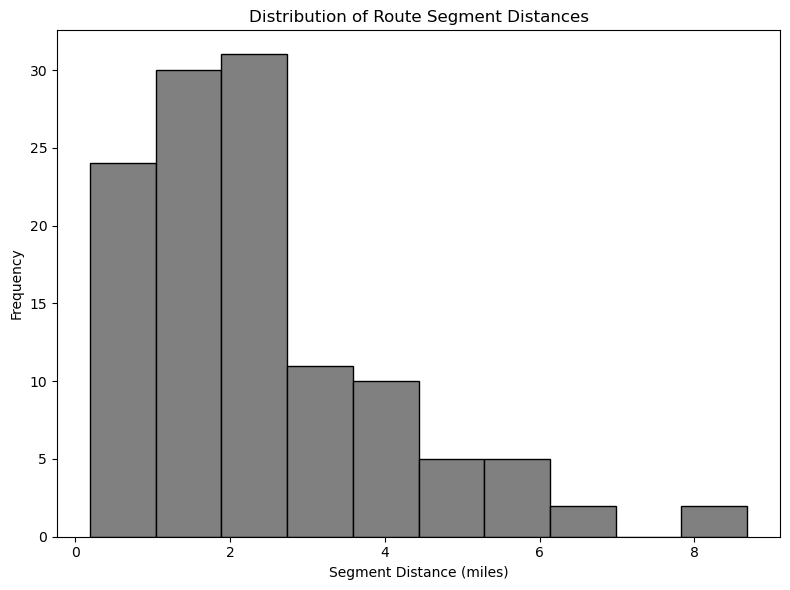

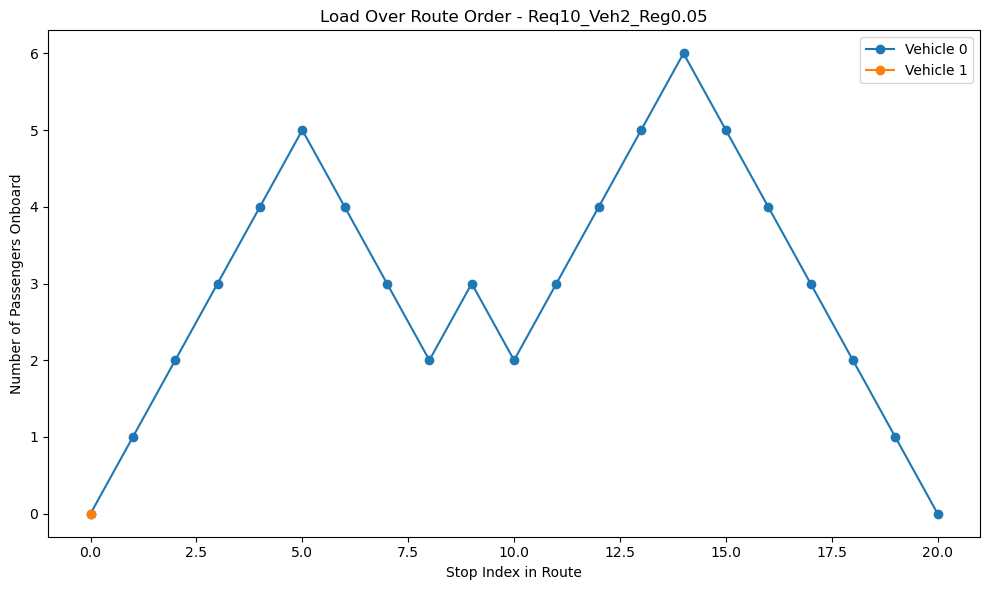

Scatter plot of pickups & dropoffs is left as an exercise if you store the request data. :)


In [8]:
import sys
import random
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import os

# Use perf_counter for high-resolution timing
from time import perf_counter

from IPython.display import IFrame

from ortools.constraint_solver import routing_enums_pb2, pywrapcp
from haversine import haversine, Unit
import folium
from folium.plugins import BeautifyIcon
import osmnx as ox
import networkx as nx

# For Jupyter display if needed
IN_JUPYTER = 'ipykernel' in sys.modules
if IN_JUPYTER:
    from IPython.display import display

# -----------------------------------
# CONFIGURATION
# -----------------------------------
TEST_CONFIGS = [
    {"num_requests": 20, "num_vehicles": 4, "region_size": 0.1},
    {"num_requests": 30, "num_vehicles": 6, "region_size": 0.2},
    {"num_requests": 10, "num_vehicles": 2, "region_size": 0.05}
]
TIME_LIMIT_SEC = 30  # Increase if needed

# --------------------------------------------------
# CREATE DATA
# --------------------------------------------------
def create_rural_data(num_requests=8, num_vehicles=3, region_size=0.1):
    """
    Generates a dial-a-ride problem with wide time windows and large capacities
    so that solutions are more likely feasible.
    """
    import numpy as np
    center_lat, center_lon = 30.1897, -82.6393
    lat_range = region_size
    lon_range = region_size

    locations = [("Depot", center_lat, center_lon)]
    requests = []
    accessibility_requirements = {}

    for i in range(num_requests):
        pickup_lat = center_lat + random.uniform(-lat_range, lat_range)
        pickup_lon = center_lon + random.uniform(-lon_range, lon_range)
        dropoff_lat = center_lat + random.uniform(-lat_range, lat_range)
        dropoff_lon = center_lon + random.uniform(-lon_range, lon_range)

        # Full-day time windows to reduce infeasibility
        window = (0, 1440)

        needs_bike = random.choice([True, False])
        needs_wheelchair = random.choice([True, False])
        
        req = {
            "name": f"R{i+1}",
            "pickup_lat": pickup_lat,
            "pickup_lon": pickup_lon,
            "dropoff_lat": dropoff_lat,
            "dropoff_lon": dropoff_lon,
            "time_window": window,
            "needs_bike": needs_bike,
            "needs_wheelchair": needs_wheelchair
        }
        requests.append(req)
    
    # Build location list
    for i, req in enumerate(requests):
        locations.append((f"{req['name']}_pickup", req["pickup_lat"], req["pickup_lon"]))
        locations.append((f"{req['name']}_dropoff", req["dropoff_lat"], req["dropoff_lon"]))
        accessibility_requirements[1 + 2*i] = (req["needs_bike"], req["needs_wheelchair"])
    
    data = {}
    data["num_vehicles"] = num_vehicles
    data["depot"] = 0
    # Large capacity so capacity is not a bottleneck
    data["vehicle_capacities"] = [9999] * num_vehicles

    num_locs = len(locations)
    dist_mat = np.zeros((num_locs, num_locs))
    for i in range(num_locs):
        for j in range(num_locs):
            coord1 = (locations[i][1], locations[i][2])
            coord2 = (locations[j][1], locations[j][2])
            dist_mat[i][j] = haversine(coord1, coord2, unit=Unit.MILES)
    
    data["distance_matrix"] = (dist_mat * 1000).astype(int).tolist()
    # Assume 30 mph
    time_mat = (dist_mat / 30.0) * 60.0
    data["time_matrix"] = (time_mat * 1000).astype(int).tolist()
    
    data["demands"] = [0] * num_locs
    data["pickups_deliveries"] = []
    data["time_windows"] = []
    
    # Depot time window: full day
    data["time_windows"].append((0, 1440))
    
    passenger_node_to_name = {}
    for i, req in enumerate(requests):
        pu_idx = 1 + 2*i
        do_idx = pu_idx + 1
        data["pickups_deliveries"].append([pu_idx, do_idx])
        data["demands"][pu_idx] = 1
        data["demands"][do_idx] = -1
        passenger_node_to_name[pu_idx] = req["name"]
        passenger_node_to_name[do_idx] = req["name"]
        data["time_windows"].append(req["time_window"])
        data["time_windows"].append(req["time_window"])
    
    # Random vehicle accessibility
    data["vehicles"] = []
    for v in range(num_vehicles):
        bike_capable = random.choice([True, False])
        wheelchair_accessible = random.choice([True, False])
        data["vehicles"].append({
            "bike_capable": bike_capable,
            "wheelchair_accessible": wheelchair_accessible
        })
    
    return data, locations, passenger_node_to_name, accessibility_requirements, requests

# --------------------------------------------------
# SOLVE ROUTING
# --------------------------------------------------
def solve_routing(data, locations, passenger_node_to_name, accessibility_requirements,
                  fs_strategy="PCA", ls_heuristic="GLS", time_limit=60):
    """
    Sets up and solves the routing problem. No skipping is allowed.
    Returns:
      metrics: dict with total distance, sim time, plus
               route-level details for further charts.
      routes: the list of routes (each route is a list of node indices).
    """
    manager = pywrapcp.RoutingIndexManager(len(data["distance_matrix"]),
                                           data["num_vehicles"],
                                           data["depot"])
    routing = pywrapcp.RoutingModel(manager)
    
    # Distance callback
    def distance_callback(from_index, to_index):
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data["distance_matrix"][from_node][to_node]
    dist_cb_idx = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(dist_cb_idx)
    
    # Demand / Capacity
    def demand_callback(from_index):
        from_node = manager.IndexToNode(from_index)
        return data["demands"][from_node]
    demand_cb_idx = routing.RegisterUnaryTransitCallback(demand_callback)
    routing.AddDimensionWithVehicleCapacity(
        demand_cb_idx, 0, data["vehicle_capacities"], True, "Capacity")
    
    # Time dimension
    def time_callback(from_index, to_index):
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data["time_matrix"][from_node][to_node]
    time_cb_idx = routing.RegisterTransitCallback(time_callback)
    routing.AddDimension(
        time_cb_idx, 30_000, 24 * 60 * 60 * 1000, False, "Time")
    time_dim = routing.GetDimensionOrDie("Time")
    
    # Time windows
    for loc_idx, tw in enumerate(data["time_windows"]):
        idx = manager.NodeToIndex(loc_idx)
        time_dim.CumulVar(idx).SetRange(tw[0]*60_000, tw[1]*60_000)
    
    # Pickup and delivery
    for (pu_idx, do_idx) in data["pickups_deliveries"]:
        pu = manager.NodeToIndex(pu_idx)
        do = manager.NodeToIndex(do_idx)
        routing.AddPickupAndDelivery(pu, do)
        routing.solver().Add(routing.VehicleVar(pu) == routing.VehicleVar(do))
        routing.solver().Add(time_dim.CumulVar(pu) <= time_dim.CumulVar(do))
    
    # Accessibility constraints
    for pu_idx, (needs_bike, needs_wheelchair) in accessibility_requirements.items():
        allowed_vehicles = []
        for v, vehicle in enumerate(data["vehicles"]):
            if needs_bike and (not vehicle["bike_capable"]):
                continue
            if needs_wheelchair and (not vehicle["wheelchair_accessible"]):
                continue
            allowed_vehicles.append(v)
        if allowed_vehicles:
            routing.SetAllowedVehiclesForIndex(allowed_vehicles, manager.NodeToIndex(pu_idx))
    
    # Solver parameters
    search_params = pywrapcp.DefaultRoutingSearchParameters()
    search_params.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    search_params.local_search_metaheuristic = routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
    search_params.time_limit.FromSeconds(time_limit)
    search_params.log_search = True
    
    solution = routing.SolveWithParameters(search_params)
    if not solution:
        print("No solution found!")
        return None, None
    
    # Extract routes
    routes = []
    for v in range(data["num_vehicles"]):
        index = routing.Start(v)
        route_nodes = []
        while not routing.IsEnd(index):
            node_idx = manager.IndexToNode(index)
            route_nodes.append(node_idx)
            index = solution.Value(routing.NextVar(index))
        routes.append(route_nodes)
    
    # Calculate total distance
    total_dist_miles = solution.ObjectiveValue() / 1000.0
    sim_time_min = (total_dist_miles / 30.0) * 60.0
    
    # ----------------------------
    # GATHER PER-VEHICLE METRICS
    # ----------------------------
    vehicle_details = []
    route_segment_distances = []  # store all legs for a global distribution
    
    for v, route in enumerate(routes):
        # Summation of route distance
        route_dist = 0.0
        # We'll count stops as "non-depot" visits
        non_depot_stops = 0
        # Track load at each step in the route
        load_over_route = []
        current_load = 0
        
        # Iterate over edges
        for i in range(len(route)-1):
            from_node = route[i]
            to_node = route[i+1]
            dist_leg = data["distance_matrix"][from_node][to_node] / 1000.0
            route_dist += dist_leg
            route_segment_distances.append(dist_leg)
            
            # Update load: add the demand of the from_node
            current_load += data["demands"][from_node]
            load_over_route.append(current_load)
            
            # Count if from_node is not the depot
            if from_node != data["depot"]:
                non_depot_stops += 1
        
        # The last node also has a demand to be accounted for
        if route:
            last_node = route[-1]
            current_load += data["demands"][last_node]
            load_over_route.append(current_load)
            if last_node != data["depot"]:
                non_depot_stops += 1
        
        vehicle_details.append({
            "vehicle_id": v,
            "route_distance": route_dist,
            "stops": non_depot_stops,
            "load_list": load_over_route
        })
    
    # Count how many requests need bike or wheelchair
    bike_requests = sum(1 for (b, w) in accessibility_requirements.values() if b)
    wheelchair_requests = sum(1 for (b, w) in accessibility_requirements.values() if w)
    # Count how many vehicles can do bike or wheelchair
    bike_vehicles = sum(1 for v in data["vehicles"] if v["bike_capable"])
    wheelchair_vehicles = sum(1 for v in data["vehicles"] if v["wheelchair_accessible"])
    
    # Return a dictionary of scenario-level info
    metrics = {
        "distance_miles": total_dist_miles,
        "sim_time_min": sim_time_min,
        "vehicle_details": vehicle_details,
        "segment_distances": route_segment_distances,
        "bike_requests": bike_requests,
        "wheelchair_requests": wheelchair_requests,
        "bike_vehicles": bike_vehicles,
        "wheelchair_vehicles": wheelchair_vehicles
    }
    return metrics, routes

# --------------------------------------------------
# VISUALIZATION
# --------------------------------------------------
def visualize_routes(routes, data, locations, passenger_node_to_name,
                     accessibility_requirements, map_filename, manager=None):
    """
    - Each bus (vehicle) gets a unique color.
    - We place a number on the pin icon for the 'order_in_route'.
    - Popup includes: Bus #, Pickup/Dropoff, Request #.
    """
    m = folium.Map(location=[locations[0][1], locations[0][2]], zoom_start=10)
    
    colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred',
              'cadetblue', 'darkgreen', 'darkpurple', 'pink']
    
    for v_idx, route in enumerate(routes):
        color = colors[v_idx % len(colors)]
        
        # Draw a polyline for the route
        coords = [(locations[n][1], locations[n][2]) for n in route]
        folium.PolyLine(coords, color=color, weight=3).add_to(m)
        
        # Label each stop
        for order_in_route, node_idx in enumerate(route, start=1):
            lat, lon = locations[node_idx][1], locations[node_idx][2]
            dem = data["demands"][node_idx]
            
            # Determine pickup vs dropoff vs depot
            if dem == 1:
                point_type = "Pickup"
                request_name = passenger_node_to_name.get(node_idx, "?")
            elif dem == -1:
                point_type = "Dropoff"
                request_name = passenger_node_to_name.get(node_idx, "?")
            else:
                point_type = "Depot"
                request_name = "Depot"
            
            # Build popup text
            # e.g. "Bus #2, Pickup of Request #5"
            popup_text = f"Bus #{v_idx}, {point_type} of {request_name}, Stop #{order_in_route}"
            
            # Create an 'AwesomeMarker' with the route order as text
            # "prefix='fa'" = FontAwesome, "icon" can be a letter or number
            # but if you want the route order (which might be multiple digits),
            # you can do something like BeautifyIcon.
            
            icon = BeautifyIcon(
                icon_shape='marker',
                number=str(order_in_route),  # the text inside the marker
                icon_size=[28, 28],
                border_width=2,
                border_color=color,
                text_color='white',
                background_color=color
            )
            
            folium.Marker(
                location=(lat, lon),
                icon=icon,
                popup=popup_text,
                tooltip=popup_text  # or something shorter
            ).add_to(m)
            IFrame("routes_Req20_Veh4_Reg0.1_20250321_100928.html", width=900, height=600)
    
    m.save(map_filename)
    print(f"Map saved to {map_filename}")

# --------------------------------------------------
# BUILD RESULTS PAGE
# --------------------------------------------------
def build_results_page(df, map_files, chart_file):
    html = "<html><head><title>Routing Results</title></head><body>"
    html += "<h1>Routing Test Results</h1>"
    html += "<h2>Aggregated Metrics</h2>"
    html += df.to_html(index=False)
    html += f"<h2>Comparison Chart (Basic)</h2><img src='{chart_file}' alt='Grouped Bar Chart'>"
    html += "<h2>Route Maps</h2><ul>"
    for cfg, mapfile in map_files.items():
        html += f"<li><a href='{mapfile}' target='_blank'>Config: {cfg}</a></li>"
    html += "</ul></body></html>"
    with open("results.html", "w") as f:
        f.write(html)
    print("Results page saved to results.html")

# --------------------------------------------------
# EXTRA ANALYSIS & PLOTTING
# --------------------------------------------------
def analyze_and_plot(all_runs_data):
    """
    Creates additional charts to illustrate:
      - Distance per vehicle
      - Stops per vehicle
      - Accessibility demand vs. supply
      - Distribution of route segment distances
      - Load over route order
      - Scatter of pickup/dropoff locations
      - Etc.
    """
    import numpy as np
    
    # 1) Bar chart of "Distance per Vehicle" by scenario
    #    We'll stack them or group them so we can see how each vehicle's distance compares.
    #    For that, we need to gather them in a single structure.
    scenario_labels = []
    all_vehicle_distances = []  # list of lists
    
    # 2) Bar chart of "Stops per Vehicle" by scenario
    all_vehicle_stops = []
    
    # 3) Accessibility Demand vs Supply
    #    We'll store them for each scenario, then do a grouped bar chart.
    bike_requests_list = []
    wheelchair_requests_list = []
    bike_vehicles_list = []
    wheelchair_vehicles_list = []
    
    # 4) Route Segment Distances (we'll gather them across all scenarios, or do separate?)
    #    We'll do a single combined histogram for demonstration.
    all_segment_dists = []
    
    # We'll also demonstrate a "Load Over Route" chart for the last scenario
    load_charts_data = None
    load_charts_label = None
    
    # We'll also do a "scatter plot of pickup/dropoff" for each scenario
    # We'll store the pickup/dropoff coords for each scenario
    scenario_pickups = {}
    scenario_dropoffs = {}
    
    for scenario_data in all_runs_data:
        scenario_label = scenario_data["Config"]
        scenario_labels.append(scenario_label)
        
        # Gather per-vehicle distances and stops
        v_dists = [v["route_distance"] for v in scenario_data["vehicle_details"]]
        v_stops = [v["stops"] for v in scenario_data["vehicle_details"]]
        
        all_vehicle_distances.append(v_dists)
        all_vehicle_stops.append(v_stops)
        
        bike_requests_list.append(scenario_data["bike_requests"])
        wheelchair_requests_list.append(scenario_data["wheelchair_requests"])
        bike_vehicles_list.append(scenario_data["bike_vehicles"])
        wheelchair_vehicles_list.append(scenario_data["wheelchair_vehicles"])
        
        # Segment distances for the histogram
        all_segment_dists.extend(scenario_data["segment_distances"])
        
        # Keep load chart data from the last scenario as an example
        load_charts_data = scenario_data["vehicle_details"]
        load_charts_label = scenario_label
        
        # For the scatter plot, we need the "requests" data if we stored it
        # We'll assume scenario_data has "requests" if we stored it. 
        # Or we can store it in "scenario_data['requests']". We'll see below how we store it.
        # If you want to store pickup / dropoff coords in scenario_data, you can do so in main().
    
    # ---- CHART 1: Distance per Vehicle by Scenario ----
    # We'll create a figure with subplots, each scenario is one subplot
    fig1, axes1 = plt.subplots(len(scenario_labels), 1, figsize=(8, 4 * len(scenario_labels)))
    if len(scenario_labels) == 1:
        axes1 = [axes1]  # make it iterable
    for idx, label in enumerate(scenario_labels):
        ax = axes1[idx]
        dist_list = all_vehicle_distances[idx]
        ax.bar(range(len(dist_list)), dist_list, color='skyblue')
        ax.set_title(f"Distance per Vehicle - {label}")
        ax.set_xlabel("Vehicle ID")
        ax.set_ylabel("Distance (miles)")
    plt.tight_layout()
    plt.savefig("distance_per_vehicle.png")
    plt.show()
    
    # ---- CHART 2: Stops per Vehicle by Scenario ----
    fig2, axes2 = plt.subplots(len(scenario_labels), 1, figsize=(8, 4 * len(scenario_labels)))
    if len(scenario_labels) == 1:
        axes2 = [axes2]
    for idx, label in enumerate(scenario_labels):
        ax = axes2[idx]
        stops_list = all_vehicle_stops[idx]
        ax.bar(range(len(stops_list)), stops_list, color='orange')
        ax.set_title(f"Stops per Vehicle - {label}")
        ax.set_xlabel("Vehicle ID")
        ax.set_ylabel("Number of stops")
    plt.tight_layout()
    plt.savefig("stops_per_vehicle.png")
    plt.show()
    
    # ---- CHART 3: Accessibility Demand vs. Supply (Grouped Bar) ----
    # We'll have four bars for each scenario: # bike requests, # wheelchair requests,
    # # vehicles with bike, # vehicles with wheelchair.
    x = range(len(scenario_labels))
    width = 0.2
    fig3, ax3 = plt.subplots(figsize=(10, 6))
    ax3.bar([xi - width for xi in x], bike_requests_list, width=width, label="Bike Requests", color='green')
    ax3.bar(x, wheelchair_requests_list, width=width, label="Wheelchair Requests", color='red')
    ax3.bar([xi + width for xi in x], bike_vehicles_list, width=width, label="Bike Vehicles", color='blue')
    # shift again for wheelchair vehicles
    ax3.bar([xi + 2*width for xi in x], wheelchair_vehicles_list, width=width, label="Wheelchair Vehicles", color='purple')
    ax3.set_xticks(x)
    ax3.set_xticklabels(scenario_labels, rotation=45)
    ax3.set_ylabel("Count")
    ax3.set_title("Accessibility Demand vs. Supply")
    ax3.legend()
    plt.tight_layout()
    plt.savefig("accessibility_demand_vs_supply.png")
    plt.show()
    
    # ---- CHART 4: Distribution of Route Segment Distances (Histogram) ----
    fig4, ax4 = plt.subplots(figsize=(8, 6))
    ax4.hist(all_segment_dists, bins=10, color='gray', edgecolor='black')
    ax4.set_title("Distribution of Route Segment Distances")
    ax4.set_xlabel("Segment Distance (miles)")
    ax4.set_ylabel("Frequency")
    plt.tight_layout()
    plt.savefig("segment_distance_hist.png")
    plt.show()
    
    # ---- CHART 5: Load Over Route Order (Line Chart) ----
    # We'll just demonstrate with the last scenario we processed
    if load_charts_data is not None:
        fig5, ax5 = plt.subplots(figsize=(10, 6))
        for vinfo in load_charts_data:
            v_id = vinfo["vehicle_id"]
            load_list = vinfo["load_list"]
            ax5.plot(range(len(load_list)), load_list, marker='o', label=f"Vehicle {v_id}")
        ax5.set_title(f"Load Over Route Order - {load_charts_label}")
        ax5.set_xlabel("Stop Index in Route")
        ax5.set_ylabel("Number of Passengers Onboard")
        ax5.legend()
        plt.tight_layout()
        plt.savefig("load_over_route.png")
        plt.show()
    
    # ---- CHART 6: Scatter Plot of Pickup/Dropoff Locations (Geographic Spread) ----
    # If you stored the requests somewhere, you can do something like:
    # For demonstration, let's just scatter the pickups vs. dropoffs for the last scenario:
    # We'll assume we have that data in scenario_data. If not, you can gather it in create_rural_data.
    # Example:
    # We'll just show how you'd do it if you had a list of requests with pickup_lat/lon, dropoff_lat/lon
    # If you want a separate scatter for each scenario, loop over them similarly.
    
    # For demonstration, we do a single scenario scatter:
    # (In the code above, we can return 'requests' from create_rural_data if needed.)
    # If you want a separate scatter for each scenario, just replicate the loop approach.
    print("Scatter plot of pickups & dropoffs is left as an exercise if you store the request data. :)")
    # Example pseudo-code:
    # lat_pickups = [r['pickup_lat'] for r in scenario_data['requests']]
    # lon_pickups = [r['pickup_lon'] for r in scenario_data['requests']]
    # lat_dropoffs = [r['dropoff_lat'] for r in scenario_data['requests']]
    # lon_dropoffs = [r['dropoff_lon'] for r in scenario_data['requests']]
    #
    # plt.figure(figsize=(8, 6))
    # plt.scatter(lon_pickups, lat_pickups, c='blue', label='Pickups')
    # plt.scatter(lon_dropoffs, lat_dropoffs, c='red', label='Dropoffs')
    # plt.title(f"Geographic Spread - {scenario_label}")
    # plt.xlabel("Longitude")
    # plt.ylabel("Latitude")
    # plt.legend()
    # plt.savefig("scatter_spread.png")
    # plt.show()

# --------------------------------------------------
# MAIN
# --------------------------------------------------
def main():
    all_runs = []
    map_files = {}
    
    for config in TEST_CONFIGS:
        num_requests = config["num_requests"]
        num_vehicles = config["num_vehicles"]
        region_size = config["region_size"]
        config_label = f"Req{num_requests}_Veh{num_vehicles}_Reg{region_size}"
        print(f"\n=== Running test config: {config_label} ===")
        
        # Modified create_rural_data returns 'requests' too
        data, locations, passenger_node_to_name, accessibility_requirements, requests = \
            create_rural_data(num_requests=num_requests,
                              num_vehicles=num_vehicles,
                              region_size=region_size)
        
        metrics, routes = solve_routing(data, locations, passenger_node_to_name,
                                        accessibility_requirements,
                                        fs_strategy="PCA", ls_heuristic="GLS",
                                        time_limit=TIME_LIMIT_SEC)
        if metrics is None:
            continue
        
        # Add scenario-level info
        metrics.update({
            "Config": config_label,
            "NumRequests": num_requests,
            "NumVehicles": num_vehicles,
            "RegionSize": region_size,
            # Store requests if you want for scatter plots, etc.
            "requests": requests
        })
        all_runs.append(metrics)
        
        ts = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        mapfile = f"routes_{config_label}_{ts}.html"
        visualize_routes(routes, data, locations, passenger_node_to_name,
                         accessibility_requirements, mapfile)
        map_files[config_label] = mapfile
    
    if not all_runs:
        print("No solutions found for any configuration!")
        return
    
    # Basic DataFrame with total distance & sim time
    df = pd.DataFrame([
        {
            "Config": r["Config"],
            "NumRequests": r["NumRequests"],
            "NumVehicles": r["NumVehicles"],
            "RegionSize": r["RegionSize"],
            "distance_miles": r["distance_miles"],
            "sim_time_min": r["sim_time_min"]
        } for r in all_runs
    ])
    
    print("\n--- Raw Results (All Configurations) ---")
    print(df)
    
    # Basic bar charts for total distance & sim time
    df_indexed = df.set_index("Config")
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    df_indexed["distance_miles"].plot(kind="bar", ax=axes[0], rot=45, width=0.5)
    axes[0].set_title("Total Distance (miles)")
    axes[0].set_ylabel("Miles")
    
    df_indexed["sim_time_min"].plot(kind="bar", ax=axes[1], rot=45, width=0.5)
    axes[1].set_title("Simulation Time (min)")
    axes[1].set_ylabel("Minutes")
    
    plt.tight_layout()
    chart_filename = "grouped_comparison.png"
    plt.savefig(chart_filename)
    plt.show()
    print(f"Basic grouped bar chart saved to {chart_filename}")
    
    # Build basic results page
    build_results_page(df, map_files, chart_filename)
    
    # Now do the extra analysis & plots
    analyze_and_plot(all_runs)

if __name__ == "__main__":
    main()
